### Wasserstein Distance Toy Example

In [2]:
import sys
sys.path.insert(0, '../')

from config import *
from dataset import MNIST, CIFAR10
from models.mnist_cnn import MNISTCNN
from trainer import train

%load_ext autoreload
%autoreload 2

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


#### Load Training & Validation Datasets \& Dataloaders

In [2]:
mnist_tri_set, mnist_val_set, mnist_tri_loader, mnist_val_loader = MNIST(64, 32)
cifar_tri_set, cifar_val_set , cifar_tri_loader, cifar_val_loader = MNIST(64, 32)
# TODO: Show dataset statistics and sample images.

#### Training a toy CNN using MNIST
We first train a toy CNN model on MNIST dataset.

In [59]:
model = MNISTCNN().to(DEVICE)
train(model = model, train_loader=mnist_tri_loader, val_loader=mnist_val_loader, num_epoch=8)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch  # 1 | training loss: 0.3848905004084364               | training acc: 0.8981709754797441
Epoch  # 1 | validation loss: 0.12933876934184577               | validation acc: 0.9618610223642172


 12%|█▎        | 1/8 [00:48<05:41, 48.73s/it]

Epoch  # 2 | training loss: 0.10788713700161862               | training acc: 0.9676839019189766
Epoch  # 2 | validation loss: 0.07408166525252431               | validation acc: 0.9759384984025559


 25%|██▌       | 2/8 [01:34<04:43, 47.28s/it]

Epoch  # 3 | training loss: 0.07097873537091792               | training acc: 0.9788945895522388
Epoch  # 3 | validation loss: 0.056490876822880794               | validation acc: 0.9819289137380192


 38%|███▊      | 3/8 [02:20<03:52, 46.53s/it]

Epoch  # 4 | training loss: 0.053240704025625425               | training acc: 0.9840585021321961
Epoch  # 4 | validation loss: 0.04801741873299366               | validation acc: 0.9838258785942492


 50%|█████     | 4/8 [03:06<03:05, 46.45s/it]

Epoch  # 5 | training loss: 0.042140562839684204               | training acc: 0.9872734541577826
Epoch  # 5 | validation loss: 0.04270411640732817               | validation acc: 0.9856230031948882


 62%|██████▎   | 5/8 [03:52<02:18, 46.30s/it]

Epoch  # 6 | training loss: 0.03438922276883361               | training acc: 0.9897554637526652
Epoch  # 6 | validation loss: 0.03906521868500019               | validation acc: 0.9866214057507987


 75%|███████▌  | 6/8 [04:39<01:32, 46.24s/it]

Epoch  # 7 | training loss: 0.028456401200597992               | training acc: 0.9917044243070362
Epoch  # 7 | validation loss: 0.03671928080491405               | validation acc: 0.9876198083067093


 88%|████████▊ | 7/8 [05:26<00:46, 46.45s/it]

Epoch  # 8 | training loss: 0.023756266558138683               | training acc: 0.9932869136460555
Epoch  # 8 | validation loss: 0.03605541249888951               | validation acc: 0.9877196485623003


100%|██████████| 8/8 [06:12<00:00, 46.53s/it]


In [23]:
torch.save(model, MODEL_SAVE_PATH)

In [3]:
model = torch.load(MODEL_SAVE_PATH)

#### Wasserstein Distance

In [15]:
def cost_matrix(X, Y):
    # TODO: Change this to more generic version
    if len(X.shape) == 2:
        N,D = X.shape
        M,D = Y.shape
        return (1 - torch.eye(N, M)).to(DEVICE)
    
    if len(X.shape) == 3:
        B,N,D = X.shape
        B,M,D = Y.shape
        return torch.unsqueeze(1 - torch.eye(N, M), 0).repeat(B, 1, 1).to(DEVICE)

In [6]:
def label_2_onehot(label, C, device):
    # transform the InD labels into one-hot vector
    assert type(label) == torch.Tensor

    size = label.shape[0]
    if len(label.shape) == 1:
        label = torch.unsqueeze(label, 1)
    
    label = label % C
    
    label_onehot = torch.FloatTensor(size, C).to(device)

    label_onehot.zero_()
    label_onehot.scatter_(1, label, 1)
    return label_onehot

In [60]:
def sink_dist_test(input, target, C, device):
    
    test_label_onehot = label_2_onehot(target, C, device)
    test_label_onehot = torch.unsqueeze(test_label_onehot, -1)
    test_input = torch.unsqueeze(input, -1)
    ##Loss value for InD samples 
    #Wasserstein-1 distance
    # test_loss = SamplesLoss("sinkhorn", p=2, blur=1., cost=cost_matrix)
    test_loss = SamplesLoss("sinkhorn", p=2, blur=1.)
    # ic(test_input.shape)
    # ic(test_input[:,:,0].shape)
    # ic(test_label_onehot[:,:,0].shape)
    # ic(test_label_onehot.shape)
    test_loss_value = test_loss(test_input[:,:,0], test_input, test_label_onehot[:,:,0], test_label_onehot)
    
    return test_loss_value

def sink_dist_test_v2(input, C, device):
    
    all_class = torch.LongTensor([i for i in range(C)]).to(device)
    all_class_onehot = label_2_onehot(all_class, C, device)
    ##reshape into (B,N,D)
    all_class_onehot = torch.unsqueeze(all_class_onehot, -1)
    test_input = torch.unsqueeze(input, -1)
    test_batch_size = test_input.shape[0]
    test_loss_values = torch.zeros(test_batch_size, C).to(device)
    # Approximate Wasserstein distance
    test_loss = SamplesLoss("sinkhorn", p=2, blur=1., cost = cost_matrix) 
    # ic(test_batch_size)
    for b in range(test_batch_size):
        # ic(test_input.shape)
        input_b = test_input[b:b+1,:,:].repeat(C, 1, 1)
        # ic(input_b.shape)
        # ic(input_b[0:1,:,0].shape)
        # ic(all_class_onehot[:,:,0].shape)
        # ic(all_class_onehot.shape)
        # Modified the line below
        test_loss_values[b] = torch.tensor([test_loss(input_b[c:c+1,:,0], input_b[c:c+1:,:], all_class_onehot[c:c+1,:,0], \
                                            all_class_onehot[c:c+1:,:]) for c in range(C)])
    
    return test_loss_values.min(dim=1)[0]


#### Wasserstein Distance Toy Example Sanity Check

In [52]:
# Simple Sanity Check
def example_wass_loss_ind(img_id_lst):
    wass_loss = []
    for id in img_id_lst:
        test_sample, test_label = mnist_tri_set.__getitem__(id)
        # ic(test_sample.shape)
        test_logits = model(test_sample.unsqueeze(0))
        test_softmax = torch.softmax(test_logits, dim=-1)
        # ic(test_softmax.shape)
        # pred = torch.argmax(test_logits, dim=1)
        # ic(test_softmax)
        # ic(pred)
        # ic(test_label)
        # one_hot_eg = label_2_onehot(torch.tensor([test_label]), 10, DEVICE)
        sample_wass_loss = sink_dist_test(test_softmax, torch.tensor([test_label]), 10, DEVICE)
        wass_loss.append(sample_wass_loss)
    return torch.tensor(wass_loss)

In [42]:
ic(mnist_tri_set)
ic(cifar_tri_set)

ic| mnist_tri_set: Dataset MNIST
                       Number of datapoints: 60000
                       Root location: ./Datasets
                       Split: Train
                       StandardTransform
                   Transform: Compose(
                                  ToTensor()
                              )
ic| cifar_tri_set: Dataset MNIST
                       Number of datapoints: 60000
                       Root location: ./Datasets
                       Split: Train
                       StandardTransform
                   Transform: Compose(
                                  ToTensor()
                              )


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./Datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [79]:
def run_ind_wass_loss_mc():
    img_id_lst = torch.randint(low=0, high=60000, size=(2000,))
    wass_loss_eg = example_wass_loss_ind(img_id_lst)
    mean_wass_loss = torch.mean(wass_loss_eg)
    return wass_loss_eg, mean_wass_loss

wass_loss_eg_ind, mean_wass_loss_ind = run_ind_wass_loss_mc()
ic(mean_wass_loss_ind)
# Experiments using Monte Carlo replications
# num_mc, ind_mc_results = 10, []
# for mc in range(num_mc):
#     wass_loss_eg, mean_wass_loss = run_ind_wass_loss_mc()
#     ind_mc_results.append(mean_wass_loss)
# ic(np.mean(ind_mc_results))

ic| mean_wass_loss_ind: tensor(0.0020)


tensor(0.0020)

In [82]:
# Sanity Check
def example_wass_loss_ood(img_id_lst):
    wass_loss = []
    for id in img_id_lst:
        OOD_sample = cifar_tri_set.__getitem__(id)[0].mean(0, keepdim=True)
        OOD_logits = model(OOD_sample.unsqueeze(0))
        # ic(OOD_logits.shape)
        OOD_softmax = torch.softmax(OOD_logits, dim=1)
        # ic(OOD_softmax.shape)
        # pred = torch.argmax(OOD_logits, dim=1)
        # ic(OOD_softmax)
        # ic(pred)
        # Sanity check for OOD wasserstein distance
        OOD_wass_loss = sink_dist_test_v2(input=OOD_softmax, C=torch.tensor(10), device=DEVICE)
        # ic(OOD_wass_loss)
        wass_loss.append(OOD_wass_loss)
    return torch.tensor(wass_loss)    

def run_ood_wass_loss_mc():
    img_id_lst = torch.randint(low=0, high=60000, size=(2000,))
    wass_loss_eg = example_wass_loss_ood(img_id_lst)
    mean_wass_loss = torch.mean(wass_loss_eg)
    return wass_loss_eg, mean_wass_loss

wass_loss_eg_ood, mean_wass_loss_ood = run_ood_wass_loss_mc()
ic(mean_wass_loss_ood)
# num_mc, ood_mc_results = 10, []
# for mc in range(num_mc):
#     img_id_lst = torch.randint(low=0, high=60000, size=(2000,))
#     wass_loss_eg = example_wass_loss_ood(img_id_lst)
#     mean_wass_loss = torch.mean(wass_loss_eg)
#     # ic(mean_wass_loss)
#     ood_mc_results.append(mean_wass_loss)
# ic(np.mean(ood_mc_results))

ic| mean_wass_loss_ood: tensor(0.0033)


tensor(0.0033)

#### Visualize Toy Examples

ic| len(wass_loss_eg_ind): 2000


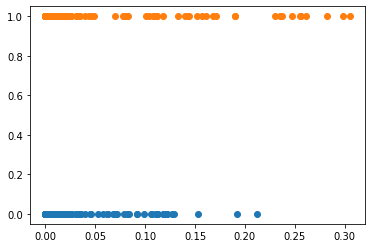

ic| len(wass_loss_eg_ood): 2000


2000

In [83]:
# Plot in-distribution data points wass loss
ic(len(wass_loss_eg_ind))
plt.scatter(wass_loss_eg_ind, np.zeros(2000))
plt.scatter(wass_loss_eg_ood, np.ones(2000))
plt.show()
# Plot ood data points wass loss
ic(len(wass_loss_eg_ood))
